## Basic Data Analysis for Kaggle Prudential Dataset

The Kaggle Prudential dataset consists of 59,381 observations and 127 categories.  The goal of the competition was to use the dataset to build the 'best fit' model that predicts the response category using the data.  There are eight response categories, and they are ordinal, from 1 to 8.

The descriptive variables can be put in three rough classes:  Demographic, Product and Insurance, and Medical History.  Product and Insurance includes information revealed by the applicant, in terms of which product they have applied for, and information about past assessments and choices by the applicant.  The demographic information contains both personal (age,weight,height,bmi), employment and family history information.  These are clearly independent variables.  The thid class is medical history, this includes both the medical history and medical keywords categories.

Below I will cover some of the more interesting results from the data, and talk about some of the potential data issues.

The response variable, or risk category, is ordinal and ranges from 1 to 8.  Below I've shown the distribution of the observations across risk categories:



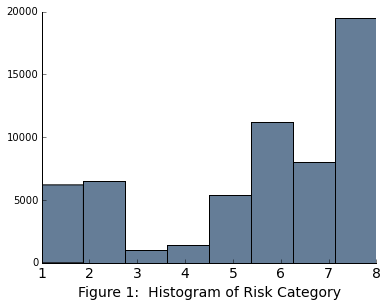

In [28]:
from numpy import loadtxt, zeros, ones, array, linspace, logspace
from pylab import scatter, show, title, xlabel, ylabel, plot, contour
import csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
traindf = pd.read_csv("train.csv")

#Histogram for response variables to get an idea of distribution of response
plt.figure(figsize=(6,4.5))
plt.hist(traindf['Response'],color="#657d97", bins=8)
ax = plt.subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.xticks(fontsize=14)
plt.xlabel('Figure 1:  Histogram of Risk Category', fontsize=14)


A couple of things to note about the distribution across risk categories.  First, it is bimodal.  It seems that the risk levels are either high or low, with few in the middle.  Unless the underlying population is bimodal thissuggests that either the categories are not distributed evenly across the population, in which case a linear predictive model may be a bad fit for the data, or that the pricing structure for the products sold by Prudential encourage both high-risk and low-risk applicants, but do not encourage mid-risk applicants.  It is unlikely that an optimal pricing structure would involve pooling in the tails.  


When we break down riskcategories by age, we find a slightly different pattern:

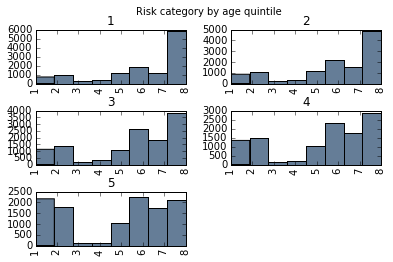

In [26]:
traindf['Age_Bins']=pd.qcut(traindf['Ins_Age'], 5, labels=False)
traindf['Age_Bins'] = traindf['Age_Bins']+1

axes = traindf['Response'].hist(by=traindf['Age_Bins'], color="#657d97", bins=8, grid=False)
plt.suptitle('Risk category by age quintile')
plt.show()